# Wrangle and Analyze Twitter dog data

Hagop Bozawglanian

## Table of Contents
- [Gather](#gather)
- [Assess](#assess)
- [Clean](#clean)
- [Analysis](#analysis)
- [Sources](#sources)

<a id='gather'></a>
## Gather

Archive File:

In [1]:
#import packages
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tweepy import OAuthHandler
from timeit import default_timer as timer
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
#create twitter archive df
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#confirm read-in
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Image Predictions:

In [4]:
#request the image predictions tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

r = requests.get(url)

In [5]:
#create a folder to store images
folder_name = 'dog_images'

# Make directory if it doesn't already exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [6]:
#save tsv file to dog_images folder and name it the last piece of the url
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(r.content)

In [7]:
#confirm read-in
df_image = pd.read_csv('dog_images/image-predictions.tsv', sep='\t')
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Twitter API:

In [8]:
#setup tweepy

consumer_key = '6E1jbg3Wyv181GWo7h4kHgd8d'
consumer_secret = 'UqoHdLxP2u2s8jSmsw9k5iIZztZqrW8UFA9YA0pivCNVFpbEYl'
access_token = '379633951-JQvOnaFvdiEKpta9WT4QNfIQbRtAnvgDNvMYEDto'
access_secret = 'CRXyMlLp8hBWnaeAy2sR2ZPZJ7iijOHiqR2WgVMgnKmaL'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [9]:
#test authentication
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print(tweet.text)

RT @jasonrmcintyre: Nobody gave Dak the memo? Never, ever throw at Stephon Gilmore. 

What a pick. Guy is incredible. Best cornerback in th…
RT @whosalex: gonna tell my kids this was eminem https://t.co/oszHTbaCe4
RT @MSCloud: #Blockchain technology will dramatically improve business processes, making infrastructure more reliable and less reliant on t…
👖 Introducing Wrangler Peekaboos for Men 👖

Watch the full #CutForTime: https://t.co/UFvc5lkVJB https://t.co/N91WXv5k2D
Check out our spoiler-filled review of The Mandalorian episode 3.

The latest episode maintains the swagger and act… https://t.co/OXtYiWcOZ3
Milton Green, who is black, was in his St. Louis driveway. A police officer for a decade, he saw a man with a gun f… https://t.co/fgcEjcDLr0
Save up to 25% on MORDHAU content and jump into the medieval multiplayer slasher well-equipped!

Don't miss out on… https://t.co/5FPPKpWkTN
nxtedition (@nxtedition) is hiring https://t.co/R8kTXJimov #ffmpeg #html
My thoughts on this are that H

In [10]:
#create list of unique tweet ids
twitter_ids = list(df_archive.tweet_id.unique())
print(twitter_ids)

[892420643555336193, 892177421306343426, 891815181378084864, 891689557279858688, 891327558926688256, 891087950875897856, 890971913173991426, 890729181411237888, 890609185150312448, 890240255349198849, 890006608113172480, 889880896479866881, 889665388333682689, 889638837579907072, 889531135344209921, 889278841981685760, 888917238123831296, 888804989199671297, 888554962724278272, 888202515573088257, 888078434458587136, 887705289381826560, 887517139158093824, 887473957103951883, 887343217045368832, 887101392804085760, 886983233522544640, 886736880519319552, 886680336477933568, 886366144734445568, 886267009285017600, 886258384151887873, 886054160059072513, 885984800019947520, 885528943205470208, 885518971528720385, 885311592912609280, 885167619883638784, 884925521741709313, 884876753390489601, 884562892145688576, 884441805382717440, 884247878851493888, 884162670584377345, 883838122936631299, 883482846933004288, 883360690899218434, 883117836046086144, 882992080364220416, 882762694511734784,

In [11]:
#query twitter api and store to JSON
count = 0
errors = {}
start = timer()

#pull all the tweets and store to a file
with open('tweets_json.txt', 'w') as outfile:
    for twitter_id in twitter_ids:
        count += 1
        print(str(count) + ": " + str(twitter_id))
        try:
            tweet = api.get_status(twitter_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            errors[twitter_id] = e
            pass
end = timer()
print(end - start)
print(errors)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
1311: 707038192327901184
Success
13

1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
1560: 6885

Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Rate limit reached. Sleeping for: 727
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Succe

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
23

In [12]:
#read json into dataframe
tweet_list = pd.DataFrame(columns=['tweet_id', 'id_val', 'retweets', 'favorites'])
with open('tweets_json.txt') as json_file:
    for line in json_file:
        data = json.loads(line)
        tweet_id = data['id_str']
        id_val = data['id']
        retweets = data['retweet_count']
        favorites = data['favorite_count']
        tweet_list = tweet_list.append(pd.DataFrame([[tweet_id, id_val, retweets, favorites]],
                                        columns=['tweet_id', 'id_val','retweets', 'favorites']))
tweet_list = tweet_list.reset_index(drop=True)

In [13]:
#confirmation that it read json properly
tweet_list.head()

,tweet_id,id_val,retweets,favorites
0,892420643555336193,892420643555336193,7861,36910
1,892177421306343426,892177421306343426,5834,31761
2,891815181378084864,891815181378084864,3853,23930
3,891689557279858688,891689557279858688,8034,40225
4,891327558926688256,891327558926688256,8685,38422


In [14]:
tweet_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 4 columns):
tweet_id     2333 non-null object
id_val       2333 non-null object
retweets     2333 non-null object
favorites    2333 non-null object
dtypes: object(4)
memory usage: 73.0+ KB


In [15]:
tweet_list.describe()

,tweet_id,id_val,retweets,favorites
count,2333,2333,2333,2333
unique,2333,2333,1692,2001
top,842765311967449089,667495797102141441,533,0
freq,1,1,5,165


<a id='assess'></a>
## Assess

In [16]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [17]:
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [18]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [19]:
#check if names are valid
df_archive.name.value_counts()

None           745
a               55
Charlie         12
Lucy            11
Oliver          11
Cooper          11
Lola            10
Tucker          10
Penny           10
Winston          9
Bo               9
Sadie            8
the              8
Daisy            7
an               7
Buddy            7
Bailey           7
Toby             7
Scout            6
Jack             6
Leo              6
Jax              6
Rusty            6
Milo             6
Koda             6
Oscar            6
Dave             6
Stanley          6
Bella            6
Louis            5
              ... 
Charleson        1
Hero             1
Goose            1
Striker          1
Pavlov           1
Staniel          1
Cheryl           1
Arlen            1
Ricky            1
Mingus           1
Shakespeare      1
Autumn           1
Kingsley         1
by               1
Jay              1
Sparky           1
Ralphé           1
Jeremy           1
Leonidas         1
Orion            1
Sandra           1
Tedrick     

In [20]:
#confirm no duplicated tweet ids
df_archive.tweet_id.value_counts()

749075273010798592    1
741099773336379392    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
700462010979500032    1
780858289093574656    1
699775878809702401    1
880095782870896641    1
760521673607086080    1
776477788987613185    1
691820333922455552    1
715696743237730304    1
714606013974974464    1
760539183865880579    1
813157409116065792    1
676430933382295552    1
743510151680958465    1
837012587749474308    1
833722901757046785    1
818259473185828864    1
670704688707301377    1
667160273090932737    1
674394782723014656    1
672082170312290304    1
670093938074779648    1
759923798737051648    1
809920764300447744    1
805487436403003392    1
838085839343206401    1
                     ..
763956972077010945    1
870308999962521604    1
720775346191278080    1
785927819176054784    1
783347506784731136    1
775733305207554048    1
834209720923721728    1
825026590719483904    1
758405701903519748    1
668986018524233728    1
6909388994772213

In [21]:
#check for repeated urls
df_archive.expanded_urls.value_counts()

https://www.gofundme.com/my-puppys-double-cataract-surgery,https://twitter.com/dog_rates/status/825026590719483904/photo/1,https://twitter.com/dog_rates/status/825026590719483904/photo/1                                                                                                                   2
https://twitter.com/dog_rates/status/859196978902773760/video/1                                                                                                                                                                                                                                              2
https://www.loveyourmelon.com/pages/ourstory,https://twitter.com/dog_rates/status/820314633777061888/photo/1,https://twitter.com/dog_rates/status/820314633777061888/photo/1,https://twitter.com/dog_rates/status/820314633777061888/photo/1                                                                 2
https://twitter.com/dog_rates/status/791406955684368384/photo/1,https://twitter.com/dog_rat

In [22]:
#make sure dog category values are proper 
df_archive.doggo.value_counts()


None     2259
doggo      97
Name: doggo, dtype: int64

In [23]:
df_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [24]:
df_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [25]:
df_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [26]:
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [27]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
df_image.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
Cardigan                      19
web_site                      19
Maltese_dog                   18
Eskimo_dog                    18
beagle                        18
Shetland_sheepdog             18
teddy                         18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [29]:
df_image.p2.value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
French_bulldog                     41
Chesapeake_Bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
Eskimo_dog                         27
Pembroke                           27
collie                             27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
Samoyed                            20
miniature_pinscher                 20
chow                               20
malinois                           20
toy_terrier                        20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [30]:
df_image.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
cocker_spaniel                    31
beagle                            31
toy_poodle                        29
Pekinese                          29
Pomeranian                        29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
French_bulldog                    26
malamute                          26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Boston_bull                       17
Shetland_sheepdog                 17
L

In [31]:
tweet_list

,tweet_id,id_val,retweets,favorites
0,892420643555336193,892420643555336193,7861,36910
1,892177421306343426,892177421306343426,5834,31761
2,891815181378084864,891815181378084864,3853,23930
3,891689557279858688,891689557279858688,8034,40225
4,891327558926688256,891327558926688256,8685,38422
5,891087950875897856,891087950875897856,2894,19335
6,890971913173991426,890971913173991426,1906,11261
7,890729181411237888,890729181411237888,17567,62239
8,890609185150312448,890609185150312448,3988,26600
9,890240255349198849,890240255349198849,6834,30446


In [32]:
tweet_list.query('tweet_id != id_val')

,tweet_id,id_val,retweets,favorites
0,892420643555336193,892420643555336193,7861,36910
1,892177421306343426,892177421306343426,5834,31761
2,891815181378084864,891815181378084864,3853,23930
3,891689557279858688,891689557279858688,8034,40225
4,891327558926688256,891327558926688256,8685,38422
5,891087950875897856,891087950875897856,2894,19335
6,890971913173991426,890971913173991426,1906,11261
7,890729181411237888,890729181411237888,17567,62239
8,890609185150312448,890609185150312448,3988,26600
9,890240255349198849,890240255349198849,6834,30446


In [33]:
tweet_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 4 columns):
tweet_id     2333 non-null object
id_val       2333 non-null object
retweets     2333 non-null object
favorites    2333 non-null object
dtypes: object(4)
memory usage: 73.0+ KB


### Quality

***archive* table**

- 'timestamp' is string object
- contains retweets (remove messages with retweet information)
- 'source' is embedded in URL
- incorrect values in ratings

***images* table**

- there are 2075 records, when the archived set has 2356, missing 281 records
- camelcase issues add extra incorrect values

***twitter* table**

- there are 2333 records, when the archived set has 2356, missing 23 records
- tweet_id and id_val are string and not int

### Tidiness

- It would make sense to merge all the tables into one table and drop irrelevant columns.
- p1, p1_conf, p2, p2_conf, p3, p3_conf not descriptive enough column titles

<a id='clean'></a>
## Clean

In [34]:
df_archive_clean = df_archive.copy()
df_images_clean = df_image.copy()
df_tweets_clean = tweet_list.copy()

### Incorrect data type

***twitter*: tweet_id, and id_val are not int**

**Define**

Must convert the tweet_id and id_val to int from string to manipulate later.

**Code**

In [35]:
df_tweets_clean = df_tweets_clean.astype({'tweet_id': int, 'id_val': int})

**Test**

In [36]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 4 columns):
tweet_id     2333 non-null int64
id_val       2333 non-null int64
retweets     2333 non-null object
favorites    2333 non-null object
dtypes: int64(2), object(2)
memory usage: 73.0+ KB


***archive*: timestamp is string object**

**Define**

Must convert the timestamp to datetime obj.

**Code**

In [37]:
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

**Test**

In [38]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### Clean Data

***images*: camelcase issues add extra incorrect values**

**Define**

Convert all text for the dog categorization to lowercase.

**Code**

In [39]:
df_images_clean.p1 = df_images_clean.p2.str.lower()

In [40]:
df_images_clean.p2 = df_images_clean.p2.str.lower()

In [41]:
df_images_clean.p3 = df_images_clean.p2.str.lower()

**Test**

In [42]:
df_images_clean.p1.value_counts()

labrador_retriever                104
golden_retriever                   92
cardigan                           74
chihuahua                          44
pomeranian                         42
french_bulldog                     41
chesapeake_bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
siberian_husky                     33
miniature_poodle                   33
beagle                             28
eskimo_dog                         27
pembroke                           27
collie                             27
kuvasz                             26
italian_greyhound                  22
american_staffordshire_terrier     21
pekinese                           21
samoyed                            20
chow                               20
toy_terrier                        20
malinois                           20
miniature_pinscher                 20
norwegian_elkhound                 19
boston_bull                        19
staffordshir

### Missing Data

***twitter*: missing 23 records**

**Define**


When we pulled data from twitter there were tweets marked no status, which means they were probably deleted. For this reason I will delete them.

**Code**

In [43]:
#return tweet_ids in `archives` and not in `tweets`
set_archive = set(df_archive_clean['tweet_id'])
set_twitter = set(df_tweets_clean['tweet_id'])
diff1 = set_archive.difference(set_twitter)

In [44]:
#remove values from `archive` from diff above
df_archive_clean = df_archive_clean[~df_archive_clean['tweet_id'].isin(diff1)]

**Test**

In [45]:
#confirm correct number of tweets_ids
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2333 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2333 non-null datetime64[ns]
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           165 non-null float64
retweeted_status_user_id      165 non-null float64
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null int64
rating_denominator            2333 non-null int64
name                          2333 non-null object
doggo                         2333 non-null object
floofer                       2333 non-null object
pupper                        2333 non-null object
puppo                         2333 non-null object
dtypes: datetime64[ns](1

***images*: there are 2075 records, when the archived set has 2356, missing 281 records**

**Define**

Must remove rows with the missing data because I do not have the source to pull.

**Code**

In [46]:
#will use the same method as above
set_archive = set(df_archive_clean['tweet_id'])
set_image = set(df_images_clean['tweet_id'])
diff2 = set_archive.difference(set_image)

In [47]:
df_archive_clean = df_archive_clean[~df_archive_clean['tweet_id'].isin(diff2)]

**Test**

In [48]:
#confirm correct number of tweets_ids
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2061 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2061 non-null datetime64[ns]
source                        2061 non-null object
text                          2061 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2061 non-null object
rating_numerator              2061 non-null int64
rating_denominator            2061 non-null int64
name                          2061 non-null object
doggo                         2061 non-null object
floofer                       2061 non-null object
pupper                        2061 non-null object
puppo                         2061 non-null object
dtypes: datetime64[ns](1), 

### Addressing Tidiness

**Join all datasets**

**Define**

Merge twitter to archive, then merge images to archive.

**Code**

In [49]:
#first merge
df_archive_clean = pd.merge(df_archive_clean, df_tweets_clean, on='tweet_id', how='left')

In [50]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 20 columns):
tweet_id                      2061 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2061 non-null datetime64[ns]
source                        2061 non-null object
text                          2061 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2061 non-null object
rating_numerator              2061 non-null int64
rating_denominator            2061 non-null int64
name                          2061 non-null object
doggo                         2061 non-null object
floofer                       2061 non-null object
pupper                        2061 non-null object
puppo                         2061 non-null object
id_val                     

In [51]:
#second merge
df_archive_clean = pd.merge(df_archive_clean, df_images_clean, on='tweet_id', how='left')

In [52]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 31 columns):
tweet_id                      2061 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2061 non-null datetime64[ns]
source                        2061 non-null object
text                          2061 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2061 non-null object
rating_numerator              2061 non-null int64
rating_denominator            2061 non-null int64
name                          2061 non-null object
doggo                         2061 non-null object
floofer                       2061 non-null object
pupper                        2061 non-null object
puppo                         2061 non-null object
id_val                     

**Test**

In [53]:
df_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,bagel,0.097049,False,bagel,0.085851,False,bagel,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,pekinese,0.323581,True,pekinese,0.090647,True,pekinese,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,malamute,0.716012,True,malamute,0.078253,True,malamute,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1,labrador_retriever,0.170278,False,labrador_retriever,0.168086,True,labrador_retriever,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2,english_springer,0.555712,True,english_springer,0.225770,True,english_springer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,1,irish_terrier,0.425595,True,irish_terrier,0.116317,True,irish_terrier,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1,border_collie,0.341703,True,border_collie,0.199287,True,border_collie,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,2,eskimo_dog,0.566142,True,eskimo_dog,0.178406,True,eskimo_dog,0.076507,True
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,1,irish_setter,0.487574,True,irish_setter,0.193054,True,irish_setter,0.118184,True
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,1,cardigan,0.511319,True,cardigan,0.451038,True,cardigan,0.029248,True


### Addressing Quality Issues

***archive*: remove retweet rows**

**Define**

Pull retweet rows, and remove them.

**Code**

In [54]:
# drop rows with retweeted status id
df_archive_clean.query('retweeted_status_id == "NaN"', inplace=True)

**Test**

In [55]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 31 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null datetime64[ns]
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
doggo                         1987 non-null object
floofer                       1987 non-null object
pupper                        1987 non-null object
puppo                         1987 non-null object
id_val                        

***archive*: remove retweet columns**

**Define**

Remove retweet columns.

**Code**

In [56]:
#make list of columns to drop
to_drop = ['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']

In [57]:
# drop list
df_archive_clean = df_archive_clean.drop(to_drop,axis=1)

**Test**

In [58]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 28 columns):
tweet_id                 1987 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1987 non-null datetime64[ns]
source                   1987 non-null object
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null int64
rating_denominator       1987 non-null int64
name                     1987 non-null object
doggo                    1987 non-null object
floofer                  1987 non-null object
pupper                   1987 non-null object
puppo                    1987 non-null object
id_val                   1987 non-null int64
retweets                 1987 non-null object
favorites                1987 non-null object
jpg_url                  1987 non-null object
img_num                  1987 non-null int64
p1                

***archive*: incorrect rating values**

**Define**

Write a regex (regular expression) to parse the data and write the new valid values into new columns, then drop the old columns.

**Code**

In [59]:
#create a temp 'correct_rating' dataframe with complete ratings parsed from text
correct_rating = df_archive_clean.text.str.extract(r'([0-9]+\.?[0-9]*)/([0-9]+)', expand=True)

In [60]:
#rename columns
col_names = {0:'new_rating_numerator',1:'new_rating_denominator'}
correct_rating = correct_rating.rename(columns=col_names)

In [61]:
correct_rating.new_rating_numerator.value_counts()

12       448
10       418
11       396
13       257
9        151
8         95
7         52
14        35
5         32
6         32
3         19
4         16
2          9
1          5
0          2
165        1
45         1
9.75       1
1776       1
88         1
84         1
11.26      1
50         1
44         1
99         1
204        1
11.27      1
144        1
60         1
13.5       1
143        1
420        1
121        1
80         1
24         1
Name: new_rating_numerator, dtype: int64

In [62]:
correct_rating.new_rating_denominator.value_counts()

10     1969
50        3
80        2
11        2
120       1
40        1
150       1
90        1
130       1
70        1
170       1
20        1
7         1
110       1
2         1
Name: new_rating_denominator, dtype: int64

In [63]:
#merge dataframes
df_archive_clean = df_archive_clean.join(correct_rating, how='outer')

In [64]:
#conver columns to floats
df_archive_clean.new_rating_numerator = df_archive_clean.new_rating_numerator.astype('float64')
df_archive_clean.new_rating_denominator = df_archive_clean.new_rating_denominator.astype('float64')

In [65]:
# drop old numerator and denominator scores
to_drop = ['rating_numerator','rating_denominator']
df_archive_clean = df_archive_clean.drop(to_drop, axis=1)

**Test**

In [66]:
#confirm merge and inclusion of decimal scores
df_archive_clean.new_rating_numerator.value_counts()

12.00      448
10.00      418
11.00      396
13.00      257
9.00       151
8.00        95
7.00        52
14.00       35
5.00        32
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
0.00         2
24.00        1
9.75         1
84.00        1
13.50        1
143.00       1
420.00       1
50.00        1
80.00        1
45.00        1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
165.00       1
11.27        1
1776.00      1
99.00        1
121.00       1
204.00       1
Name: new_rating_numerator, dtype: int64

In [67]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 28 columns):
tweet_id                  1987 non-null int64
in_reply_to_status_id     23 non-null float64
in_reply_to_user_id       23 non-null float64
timestamp                 1987 non-null datetime64[ns]
source                    1987 non-null object
text                      1987 non-null object
expanded_urls             1987 non-null object
name                      1987 non-null object
doggo                     1987 non-null object
floofer                   1987 non-null object
pupper                    1987 non-null object
puppo                     1987 non-null object
id_val                    1987 non-null int64
retweets                  1987 non-null object
favorites                 1987 non-null object
jpg_url                   1987 non-null object
img_num                   1987 non-null int64
p1                        1987 non-null object
p1_conf                   1987 non-null floa

In [68]:
#confirm column creation and compare
df_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating_numerator,new_rating_denominator
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,...,0.097049,False,bagel,0.085851,False,bagel,0.076110,False,13.0,10.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,...,0.323581,True,pekinese,0.090647,True,pekinese,0.068957,True,13.0,10.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,...,0.716012,True,malamute,0.078253,True,malamute,0.031379,True,12.0,10.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,...,0.170278,False,labrador_retriever,0.168086,True,labrador_retriever,0.040836,False,13.0,10.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,None,None,...,0.555712,True,english_springer,0.225770,True,english_springer,0.175219,True,12.0,10.0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,None,None,None,...,0.425595,True,irish_terrier,0.116317,True,irish_terrier,0.076902,False,13.0,10.0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",Jax,None,None,...,0.341703,True,border_collie,0.199287,True,border_collie,0.193548,False,13.0,10.0
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,None,None,None,...,0.566142,True,eskimo_dog,0.178406,True,eskimo_dog,0.076507,True,13.0,10.0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,Zoey,None,None,...,0.487574,True,irish_setter,0.193054,True,irish_setter,0.118184,True,13.0,10.0
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,Cassie,doggo,None,...,0.511319,True,cardigan,0.451038,True,cardigan,0.029248,True,14.0,10.0


***archive*: the regular expression made incorrect parsing errors for 24/7 and 7/11**

**Define**

Correct scores to 0/0.

**Code**

In [69]:
df_archive_clean.loc[df_archive_clean.eval('new_rating_numerator == 24'), 'new_rating_numerator'] = 0
df_archive_clean.loc[df_archive_clean.eval('new_rating_numerator == 24'), 'new_rating_denominator'] = 0

In [70]:
df_archive_clean.query('new_rating_numerator == 7 and new_rating_denominator == 11')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating_numerator,new_rating_denominator
1394,682962037429899265,NaN,NaN,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,Darrel,None,None,...,0.2786,False,chihuahua,0.155207,True,chihuahua,0.153598,False,7.0,11.0


In [71]:
df_archive_clean.loc[1662,'new_rating_numerator'] = 0
df_archive_clean.loc[1662,'new_rating_denominator'] = 0

**Test**

In [72]:
#search for numerator
df_archive_clean.query('new_rating_numerator == 24')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating_numerator,new_rating_denominator


In [73]:
df_archive_clean.query('new_rating_numerator == 24')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating_numerator,new_rating_denominator


In [74]:
df_archive_clean.query('new_rating_numerator == 7 and new_rating_denominator == 11')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating_numerator,new_rating_denominator
1394,682962037429899265,NaN,NaN,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,Darrel,None,None,...,0.2786,False,chihuahua,0.155207,True,chihuahua,0.153598,False,7.0,11.0


In [75]:
df_archive_clean.loc[1662]

tweet_id                                                 673680198160809984
in_reply_to_status_id                                                   NaN
in_reply_to_user_id                                                     NaN
timestamp                                               2015-12-07 01:47:30
source                    <a href="http://twitter.com/download/iphone" r...
text                      This is Shnuggles. I would kill for Shnuggles....
expanded_urls             https://twitter.com/dog_rates/status/673680198...
name                                                              Shnuggles
doggo                                                                  None
floofer                                                                None
pupper                                                                 None
puppo                                                                  None
id_val                                                   673680198160809984
retweets    

***archive*: source embedded in url**

**Define**

Extract the source from the url.

**Code**

In [76]:
#counts for source values
df_archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1949
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [77]:
#assign source to variable
source_url = df_archive_clean['source']

In [78]:
source_url = source_url.apply(lambda text: BeautifulSoup(text, 'html.parser').get_text())

In [79]:
#confirm updated variable
source_url.value_counts()

Twitter for iPhone    1949
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

In [80]:
#add new column, remove old column
df_archive_clean['new_source'] = source_url
df_archive_clean.drop('source',axis=1, inplace=True)

In [81]:
df_archive_clean.new_source = df_archive_clean.new_source.astype('category')

**Test**

In [82]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 28 columns):
tweet_id                  1987 non-null int64
in_reply_to_status_id     23 non-null float64
in_reply_to_user_id       23 non-null float64
timestamp                 1987 non-null datetime64[ns]
text                      1987 non-null object
expanded_urls             1987 non-null object
name                      1987 non-null object
doggo                     1987 non-null object
floofer                   1987 non-null object
pupper                    1987 non-null object
puppo                     1987 non-null object
id_val                    1987 non-null int64
retweets                  1987 non-null object
favorites                 1987 non-null object
jpg_url                   1987 non-null object
img_num                   1987 non-null int64
p1                        1987 non-null object
p1_conf                   1987 non-null float64
p1_dog                    1987 non-null boo

In [83]:
df_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,expanded_urls,name,doggo,floofer,pupper,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating_numerator,new_rating_denominator,new_source
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,None,...,False,bagel,0.085851,False,bagel,0.076110,False,13.0,10.0,Twitter for iPhone
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,None,...,True,pekinese,0.090647,True,pekinese,0.068957,True,13.0,10.0,Twitter for iPhone
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,None,...,True,malamute,0.078253,True,malamute,0.031379,True,12.0,10.0,Twitter for iPhone
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,None,...,False,labrador_retriever,0.168086,True,labrador_retriever,0.040836,False,13.0,10.0,Twitter for iPhone
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,None,None,None,...,True,english_springer,0.225770,True,english_springer,0.175219,True,12.0,10.0,Twitter for iPhone


***archive*: drop irrelevant columns**

**Define**

Drop the 'in_reply_to_status_id','in_reply_to_user_id','retweeted', 'favorited' columns.

**Code**

In [84]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 28 columns):
tweet_id                  1987 non-null int64
in_reply_to_status_id     23 non-null float64
in_reply_to_user_id       23 non-null float64
timestamp                 1987 non-null datetime64[ns]
text                      1987 non-null object
expanded_urls             1987 non-null object
name                      1987 non-null object
doggo                     1987 non-null object
floofer                   1987 non-null object
pupper                    1987 non-null object
puppo                     1987 non-null object
id_val                    1987 non-null int64
retweets                  1987 non-null object
favorites                 1987 non-null object
jpg_url                   1987 non-null object
img_num                   1987 non-null int64
p1                        1987 non-null object
p1_conf                   1987 non-null float64
p1_dog                    1987 non-null boo

In [85]:
drop_cols = ['in_reply_to_status_id','in_reply_to_user_id']

In [86]:
df_archive_clean.drop(drop_cols, axis=1, inplace=True)

**Test**

In [87]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 26 columns):
tweet_id                  1987 non-null int64
timestamp                 1987 non-null datetime64[ns]
text                      1987 non-null object
expanded_urls             1987 non-null object
name                      1987 non-null object
doggo                     1987 non-null object
floofer                   1987 non-null object
pupper                    1987 non-null object
puppo                     1987 non-null object
id_val                    1987 non-null int64
retweets                  1987 non-null object
favorites                 1987 non-null object
jpg_url                   1987 non-null object
img_num                   1987 non-null int64
p1                        1987 non-null object
p1_conf                   1987 non-null float64
p1_dog                    1987 non-null bool
p2                        1987 non-null object
p2_conf                   1987 non-null flo

***archive*: change name of columns to make them more meaningful**

**Define**

Rename the dog probability columns.

**Code**

In [88]:
#change name matrix
new_names = {'p1':'prediction_1', 'p1_conf':'confidence_1', 'p1_dog':'isdog_1',
             'p2':'prediction_2', 'p2_conf':'confidence_2', 'p2_dog':'isdog_2',
             'p3':'prediction_3', 'p3_conf':'confidence_3', 'p3_dog':'isdog_3'}

df_archive_clean = df_archive_clean.rename(columns=new_names)

**Test**

In [89]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 26 columns):
tweet_id                  1987 non-null int64
timestamp                 1987 non-null datetime64[ns]
text                      1987 non-null object
expanded_urls             1987 non-null object
name                      1987 non-null object
doggo                     1987 non-null object
floofer                   1987 non-null object
pupper                    1987 non-null object
puppo                     1987 non-null object
id_val                    1987 non-null int64
retweets                  1987 non-null object
favorites                 1987 non-null object
jpg_url                   1987 non-null object
img_num                   1987 non-null int64
prediction_1              1987 non-null object
confidence_1              1987 non-null float64
isdog_1                   1987 non-null bool
prediction_2              1987 non-null object
confidence_2              1987 non-null flo

#### Save the data to a CSV

In [90]:
df_archive_clean.to_csv('twitter_archive_master.csv')

<a id='analysis'></a>
### Analysis

In [91]:
df_final = pd.read_csv('twitter_archive_master.csv', index_col=0)

In [92]:
df_final.head()

,tweet_id,timestamp,text,expanded_urls,name,doggo,floofer,pupper,puppo,id_val,...,isdog_1,prediction_2,confidence_2,isdog_2,prediction_3,confidence_3,isdog_3,new_rating_numerator,new_rating_denominator,new_source
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,None,None,892420643555336193,...,False,bagel,0.085851,False,bagel,0.076110,False,13.0,10.0,Twitter for iPhone
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,None,None,892177421306343426,...,True,pekinese,0.090647,True,pekinese,0.068957,True,13.0,10.0,Twitter for iPhone
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,None,None,891815181378084864,...,True,malamute,0.078253,True,malamute,0.031379,True,12.0,10.0,Twitter for iPhone
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,None,None,891689557279858688,...,False,labrador_retriever,0.168086,True,labrador_retriever,0.040836,False,13.0,10.0,Twitter for iPhone
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,None,None,None,None,891327558926688256,...,True,english_springer,0.225770,True,english_springer,0.175219,True,12.0,10.0,Twitter for iPhone


In [93]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 26 columns):
tweet_id                  1987 non-null int64
timestamp                 1987 non-null object
text                      1987 non-null object
expanded_urls             1987 non-null object
name                      1987 non-null object
doggo                     1987 non-null object
floofer                   1987 non-null object
pupper                    1987 non-null object
puppo                     1987 non-null object
id_val                    1987 non-null int64
retweets                  1987 non-null int64
favorites                 1987 non-null int64
jpg_url                   1987 non-null object
img_num                   1987 non-null int64
prediction_1              1987 non-null object
confidence_1              1987 non-null float64
isdog_1                   1987 non-null bool
prediction_2              1987 non-null object
confidence_2              1987 non-null float64
isdog

In [94]:
#the new_source and timestamp lost the data type in the transition to csv
df_final.new_source = df_final.new_source.astype('category')
df_final.timestamp = pd.to_datetime(df_final['timestamp'])

In [95]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 26 columns):
tweet_id                  1987 non-null int64
timestamp                 1987 non-null datetime64[ns]
text                      1987 non-null object
expanded_urls             1987 non-null object
name                      1987 non-null object
doggo                     1987 non-null object
floofer                   1987 non-null object
pupper                    1987 non-null object
puppo                     1987 non-null object
id_val                    1987 non-null int64
retweets                  1987 non-null int64
favorites                 1987 non-null int64
jpg_url                   1987 non-null object
img_num                   1987 non-null int64
prediction_1              1987 non-null object
confidence_1              1987 non-null float64
isdog_1                   1987 non-null bool
prediction_2              1987 non-null object
confidence_2              1987 non-null float

In [96]:
df_final.describe()

,tweet_id,id_val,retweets,favorites,img_num,confidence_1,confidence_2,confidence_3,new_rating_numerator,new_rating_denominator
count,1.987000e+03,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1.987000e+03,1987.000000,1987.000000
mean,7.356264e+17,7.356264e+17,2509.533971,8431.487167,1.203322,0.593317,1.344725e-01,6.037114e-02,12.218309,10.528938
std,6.739210e+16,6.739210e+16,4491.428562,12403.816197,0.561369,0.271959,1.005706e-01,5.091543e-02,41.545142,7.337329
min,6.660209e+17,6.660209e+17,11.000000,73.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000,0.000000
25%,6.758218e+17,6.758218e+17,561.000000,1810.500000,1.000000,0.361531,5.409535e-02,1.624950e-02,10.000000,10.000000
50%,7.083495e+17,7.083495e+17,1212.000000,3793.000000,1.000000,0.587342,1.175080e-01,4.953060e-02,11.000000,10.000000
75%,7.873602e+17,7.873602e+17,2851.000000,10507.500000,1.000000,0.844583,1.950575e-01,9.180755e-02,12.000000,10.000000
max,8.924206e+17,8.924206e+17,79578.000000,159491.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,1776.000000,170.000000


#### Analysis 1: Analysis of Image Predictions

In [97]:
#seperate out prediction columns alone
df_predictions = df_final[['prediction_1', 'confidence_1', 'isdog_1','prediction_2', 'confidence_2', 'isdog_2','prediction_3', 'confidence_3', 'isdog_3']]
df_predictions

,prediction_1,confidence_1,isdog_1,prediction_2,confidence_2,isdog_2,prediction_3,confidence_3,isdog_3
0,bagel,0.097049,False,bagel,0.085851,False,bagel,0.076110,False
1,pekinese,0.323581,True,pekinese,0.090647,True,pekinese,0.068957,True
2,malamute,0.716012,True,malamute,0.078253,True,malamute,0.031379,True
3,labrador_retriever,0.170278,False,labrador_retriever,0.168086,True,labrador_retriever,0.040836,False
4,english_springer,0.555712,True,english_springer,0.225770,True,english_springer,0.175219,True
5,irish_terrier,0.425595,True,irish_terrier,0.116317,True,irish_terrier,0.076902,False
6,border_collie,0.341703,True,border_collie,0.199287,True,border_collie,0.193548,False
7,eskimo_dog,0.566142,True,eskimo_dog,0.178406,True,eskimo_dog,0.076507,True
8,irish_setter,0.487574,True,irish_setter,0.193054,True,irish_setter,0.118184,True
9,cardigan,0.511319,True,cardigan,0.451038,True,cardigan,0.029248,True


In [98]:
df_predictions = df_predictions.query('isdog_1 == True or isdog_2 == True or isdog_3 == True')
df_predictions

,prediction_1,confidence_1,isdog_1,prediction_2,confidence_2,isdog_2,prediction_3,confidence_3,isdog_3
1,pekinese,0.323581,True,pekinese,0.090647,True,pekinese,0.068957,True
2,malamute,0.716012,True,malamute,0.078253,True,malamute,0.031379,True
3,labrador_retriever,0.170278,False,labrador_retriever,0.168086,True,labrador_retriever,0.040836,False
4,english_springer,0.555712,True,english_springer,0.225770,True,english_springer,0.175219,True
5,irish_terrier,0.425595,True,irish_terrier,0.116317,True,irish_terrier,0.076902,False
6,border_collie,0.341703,True,border_collie,0.199287,True,border_collie,0.193548,False
7,eskimo_dog,0.566142,True,eskimo_dog,0.178406,True,eskimo_dog,0.076507,True
8,irish_setter,0.487574,True,irish_setter,0.193054,True,irish_setter,0.118184,True
9,cardigan,0.511319,True,cardigan,0.451038,True,cardigan,0.029248,True
10,pomeranian,0.957979,True,pomeranian,0.013884,True,pomeranian,0.008167,True


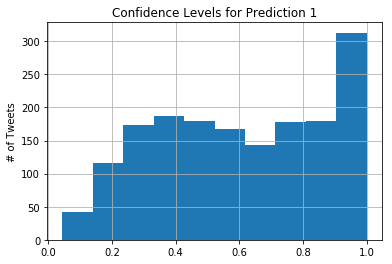

In [99]:
#confidence for prediction 1
df_predictions.confidence_1.hist()
plt.ylabel('# of Tweets')
plt.title('Confidence Levels for Prediction 1');

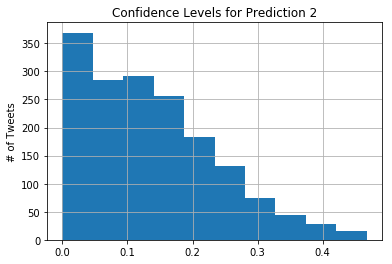

In [100]:
#confidence for prediction 2
df_predictions.confidence_2.hist()
plt.ylabel('# of Tweets')
plt.title('Confidence Levels for Prediction 2');

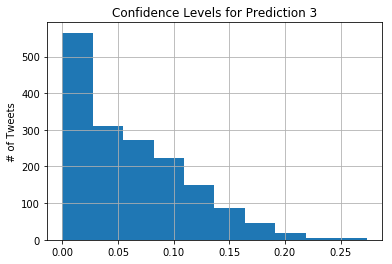

In [101]:
#confidence for prediction 3
df_predictions.confidence_3.hist()
plt.ylabel('# of Tweets')
plt.title('Confidence Levels for Prediction 3');

##### Result

**Prediction Confidences**
- Prediction 1: Confidence ranges from 0 to 100%
- Prediction 2: Confidence ranges from 0 to 50%
- Prediction 3: Confidence ranges from 0 to 30%

With this we can see that 1679 out of the 2060 rows had at least one dog in the three predictions and we can see the distribution shifting from left trailing to right trailing as the predictions continue, which is what we would expect in this situation.

#### Analysis 2: Top Dog analysis

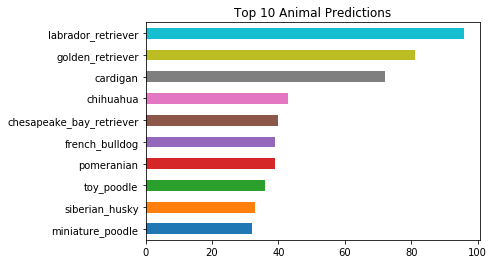

In [102]:
#checking top 10 for prediction 1
df_predictions.prediction_1.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title('Top 10 Animal Predictions');

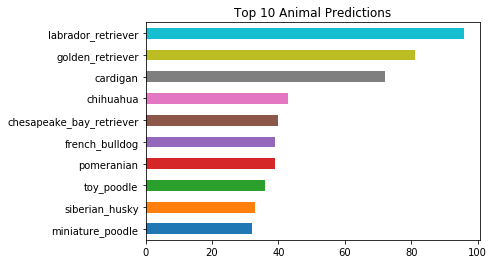

In [103]:
#checking top 10 for prediction 2
df_predictions.prediction_2.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title('Top 10 Animal Predictions');

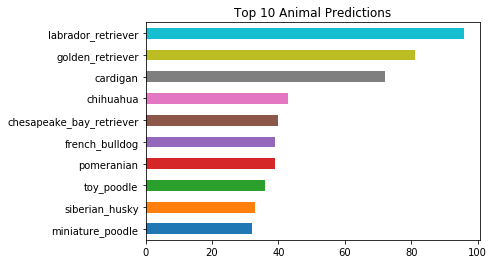

In [104]:
#checking top 10 for prediction 3
df_predictions.prediction_3.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title('Top 10 Animal Predictions');

**Result**

**Predicted Animals:**
From looking at the top ten I was able to see that the values were the same for prediction one, two, and three. It looks like the prediction is always the same for all three with different confidence levels, but the predicted animal never changes.

However we can now see the top 10 most seen/identified animals which means they are the most popular.

#### Analysis 3: Dog type analysis


In [105]:
len(df_final)

1987

In [106]:
#number of doggo
doggo = len(df_final.query('doggo == "doggo"'))
doggo, (doggo/len(df_final)*100)

(73, 3.6738802214393558)

In [107]:
#number of floofer
floofer = len(df_final.query('floofer == "floofer"'))
floofer, (floofer/len(df_final)*100)

(8, 0.40261701056869653)

In [108]:
#number of pupper
pupper = len(df_final.query('pupper == "pupper"'))
pupper, (pupper/len(df_final)*100)

(212, 10.669350780070458)

In [109]:
#number of puppo
puppo = len(df_final.query('puppo == "puppo"'))
puppo, (puppo/len(df_final)*100)

(23, 1.1575239053850024)

In [110]:
total = doggo + floofer + pupper + puppo 
total, (total/len(df_final)*100)

(316, 15.903371917463513)

In [111]:
not_dog = len(df_final) - total
not_dog

1671

#### Results: Dog categorization

- doggo: 73 of 1987      (3.67%) tweets
- floofer: 8 of 1987     (0.40%) tweets
- pupper: 212 of 1987    (10.67%) tweets
- puppo: 23 of 1987      (1.16%) tweets
- total dog: 316 of 1987 (15.9%) tweets


#### Analysis 4: Source of Tweets

In [115]:
df_final.new_source.value_counts()

Twitter for iPhone    1949
Twitter Web Client      28
TweetDeck               10
Name: new_source, dtype: int64

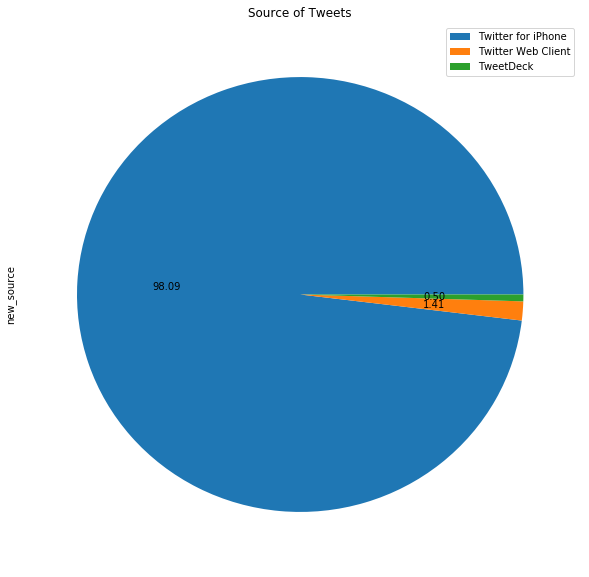

In [116]:
#create sources pie chart
plt.figure(figsize=[10,10])
plt.title('Source of Tweets')
df_final.new_source.value_counts().plot(kind='pie', legend=True, autopct='%.2f', labels=None);

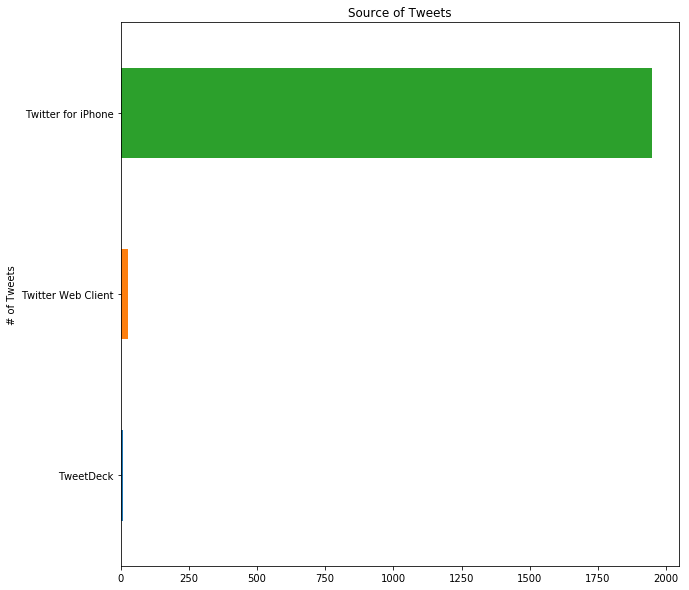

In [117]:
#create sources bar chart
plt.figure(figsize=[10,10])
plt.ylabel('# of Tweets')
plt.title('Source of Tweets')
df_final.new_source.value_counts().sort_values().plot(kind='barh');

**Result**

To no surprise, it looks like 98% of tweets came in from the iPhone application.

<a id='sources'></a>
### Sources

1. https://realpython.com/python-json/
2. http://docs.tweepy.org/en/v3.8.0/getting_started.html#hello-tweepy
3. https://stackoverflow.com/questions/28679930/how-to-drop-rows-from-pandas-data-frame-that-contains-a-particular-string-in-a-p
4. https://stackoverflow.com/questions/53189494/apply-beautifulsoup-function-to-pandas-dataframe